In [1]:
import os
import readARGdbFiles
import load_adj_mat
import get_graph_pairs_and_labels
import Graph_Isomorphism_Network
import numpy as np
import dgl
import tensorflow as tf
import numpy as np
from dgl.nn import GraphConv
import torch
import dgl
import torch
import torch.nn as nn
from dgl.nn import GraphConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-12-08 19:20:35.783213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 19:20:35.783245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 19:20:35.784108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 19:20:35.789864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 19:20:36.976148: W tensorflow/compiler/tf2

In [31]:
input_directory = "/home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso/m3D/m3D"
output_directory = "/home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D"

In [32]:
# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [33]:
# Process each file in the input directory
for filename in os.listdir(input_directory):
    input_file_path = os.path.join(input_directory, filename)
    output_file_path = os.path.join(output_directory, filename)
    adjacency_matrix = readARGdbFiles.read_graph(input_file_path)
    
    if adjacency_matrix is not None:
        # print(adjacency_matrix.shape)
        readARGdbFiles.save_adjacency_matrix(adjacency_matrix, output_file_path)

Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A00
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A01
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A02
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A03
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A04
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A05
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats3D/iso_m3D_m1000.A06
Adjacency matrix saved to /home/ericp/Coding/projects/ML-NYU/graph_iso/graph

In [30]:
def plot_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    nx.draw(G, with_labels=False, node_size=50, node_color='r', edge_color='b')
    plt.show()

In [43]:
# Example usage
mat_path = output_directory + "/iso_m3D_s27.A00"
#mat_path = "/home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats/iso_m2Dr2_s16.A01"
adj_matrix = load_adj_mat.load_adjacency_matrix(mat_path)

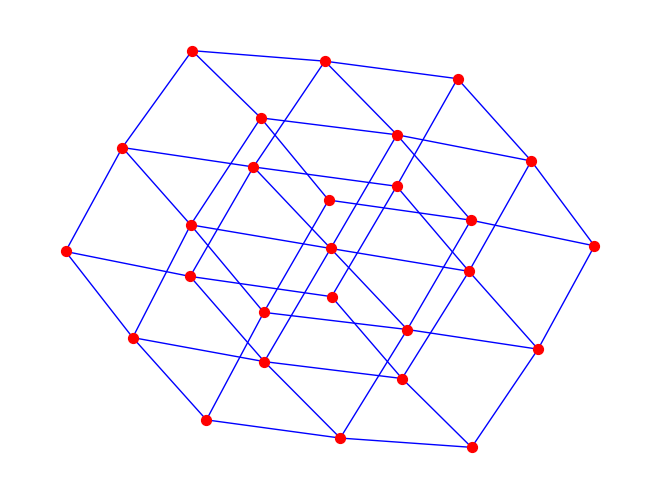

In [44]:
plot_graph(adj_matrix)

In [ ]:
# Example usage
mat_path = output_directory + "/iso_m2Dr4_s16.A00"
mat_path = "/home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2/iso/m2D/adj_mats/iso_m2Dr2_s16.A01"
adj_matrix = load_adj_mat.load_adjacency_matrix(mat_path)

In [7]:
gtr_file_path = '/home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso_m2Dr2.gtr'
adj_mat_dir_path = '/home/ericp/Coding/projects/ML-NYU/graph_iso/graphsdb_fuck/iso/m2Dr/adj_mats'

In [ ]:
graph_pairs, labels = get_graph_pairs_and_labels.load_graph_pairs_and_labels(gtr_file_path, adj_mat_dir_path)

In [15]:
type(graph_pairs)

list

In [16]:
train_pairs, test_pairs, train_labels, test_labels = train_test_split(graph_pairs, labels, test_size=0.2, random_state=42)

In [17]:
# Initialize model, loss function, and optimizer
model = Graph_Isomorphism_Network.GIN(input_dim=16, hidden_dim=32, output_dim=1)
loss_fn = Graph_Isomorphism_Network.nn.BCEWithLogitsLoss()
optimizer = Graph_Isomorphism_Network.torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
# Training step function
def train_step(model, graphs, labels):
    model.train()
    total_loss = 0
    for g, label in zip(graphs, labels):
        g_dgl = dgl.graph((np.nonzero(g[0])[0], np.nonzero(g[0])[1]))
        g_dgl = dgl.add_self_loop(g_dgl)
        h = torch.ones((g[0].shape[0], 16), dtype=torch.float32)
        
        optimizer.zero_grad()
        prediction = model(g_dgl, h)
        prediction = prediction.view(-1)  # Reshape to match label dimension
        label_tensor = torch.tensor([label], dtype=torch.float32)
        loss = loss_fn(prediction, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graphs)

In [19]:
# Test step function
def evaluate(graphs, labels):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for g, label in zip(graphs, labels):
            g_dgl = dgl.graph((np.nonzero(g[0])[0], np.nonzero(g[0])[1]))
            g_dgl = dgl.add_self_loop(g_dgl)
            h = torch.ones((g[0].shape[0], 16), dtype=torch.float32)
            
            prediction = model(g_dgl, h)
            predicted_label = torch.round(torch.sigmoid(prediction))
            correct += (predicted_label == torch.tensor([label], dtype=torch.float32)).sum().item()
            total += 1

    return correct / total

In [9]:
def plot_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    nx.draw(G, with_labels=False, node_size=50, node_color='r', edge_color='b')
    plt.show()

In [21]:
# Example training loop
for epoch in range(10):
    loss = train_step(model, train_pairs, train_labels)
    print(f"Epoch {epoch}, Loss: {loss}")
test_accuracy = evaluate(test_pairs, test_labels)
print(f"Test Accuracy: {test_accuracy}")

Epoch 0, Loss: 0.014806383495401292
Epoch 1, Loss: 3.987549958850423e-07
Epoch 2, Loss: 3.6239617202227236e-07
Epoch 3, Loss: 3.1143421693968773e-07
Epoch 4, Loss: 2.995132918925947e-07
Epoch 5, Loss: 2.661347024002225e-07
Epoch 6, Loss: 2.145766957539763e-07
Epoch 7, Loss: 1.7583368427054325e-07
Epoch 8, Loss: 1.4066695072756374e-07
Epoch 9, Loss: 1.4066695072756374e-07
Test Accuracy: 1.0


In [22]:
# Manual inspection
# Example: Select the first 5 graph pairs from the test set
sample_graph_pairs = test_pairs[:5]
sample_labels = test_labels[:5]
sample_predictions = []
for g in sample_graph_pairs:
    g_dgl = dgl.graph((np.nonzero(g[0])[0], np.nonzero(g[0])[1]))
    g_dgl = dgl.add_self_loop(g_dgl)
    h = torch.ones((g[0].shape[0], 16), dtype=torch.float32)
    
    with torch.no_grad():  # Disable gradient computation
        prediction = model(g_dgl, h)
        predicted_label = torch.round(torch.sigmoid(prediction)).item()
        sample_predictions.append(predicted_label)

Graph Pair 0: Predicted Label - 1.0, Actual Label - 1
Graph Pair 1: Predicted Label - 1.0, Actual Label - 1
Graph Pair 2: Predicted Label - 1.0, Actual Label - 1
Graph Pair 3: Predicted Label - 1.0, Actual Label - 1
Graph Pair 4: Predicted Label - 1.0, Actual Label - 1


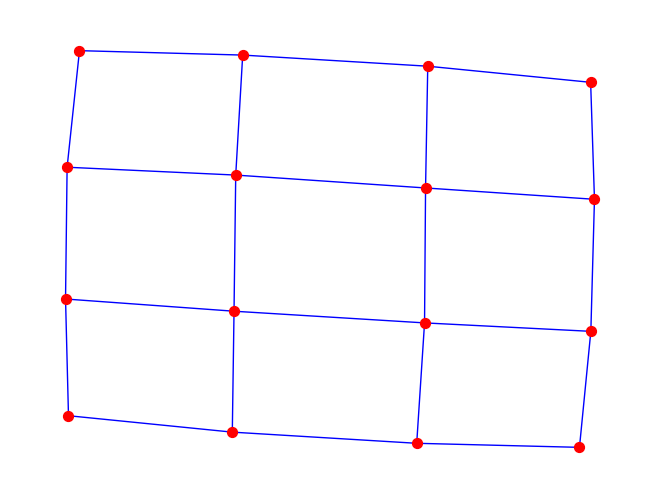

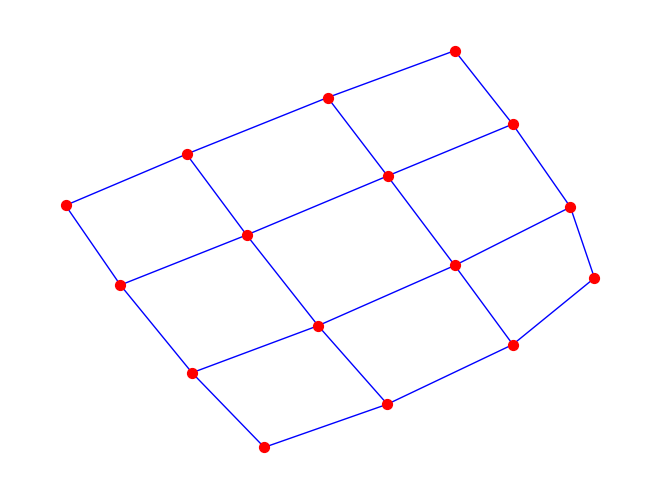

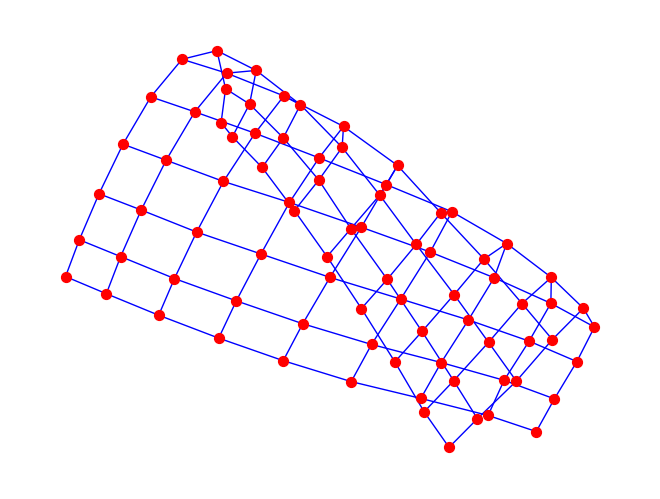

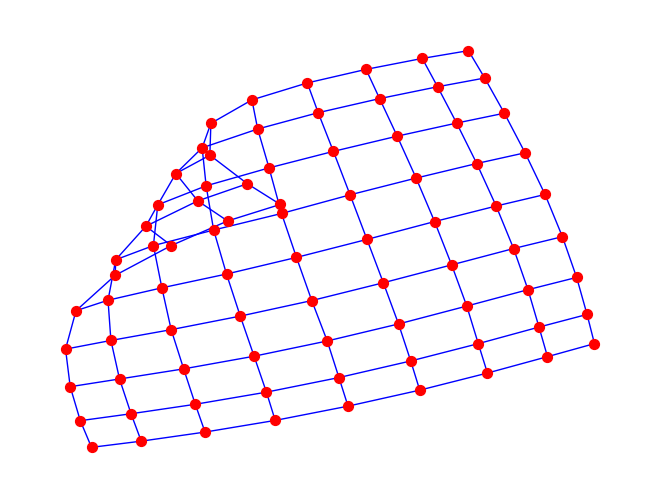

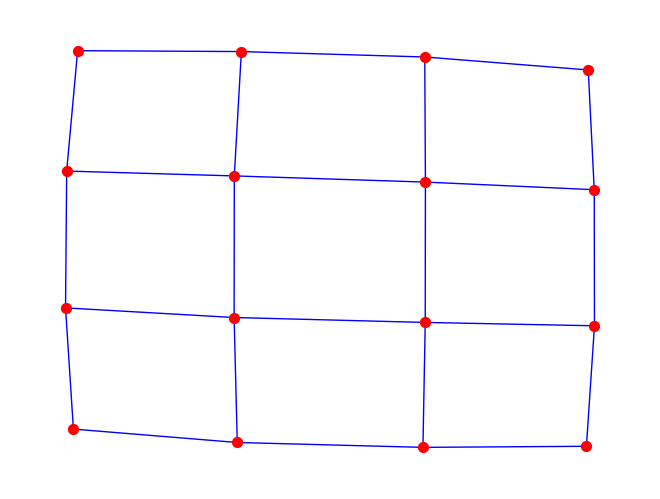

(16, 16)

In [25]:
for i, (pred, label) in enumerate(zip(sample_predictions, sample_labels)):
    print(f"Graph Pair {i}: Predicted Label - {pred}, Actual Label - {label}")
# Plot the first graph pair as an example
plot_graph(sample_graph_pairs[1][0])
plot_graph(sample_graph_pairs[1][1])
plot_graph(sample_graph_pairs[0][0])
plot_graph(sample_graph_pairs[0][1])

